<a href="https://colab.research.google.com/github/olinml2024/notebooks/blob/main/ML24_Day09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Showing Parallels Between Micrograd and Pytorch

We jumped pretty fast into some fairly complex pytorch functions.  Let's rewind a bit and look at some pretty basic functions and make sure we get the results we expect.  We will see through doing this that pytorch is very similar to micrograd.

In [156]:
import torch

# try setting requires_grad to false and see what happens
x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor(7.0, requires_grad=True)
z = x*y**2 + x*y
z.backward()
print(x.grad)            # should be y**2 + y = y**2 + 7 = 56
print(y.grad)            # should be 2*x*y + x = 2*1*7 + 1 = 15

tensor(56.)
tensor(15.)


# Revisiting Linear Regression in Pytorch

It's also nice to be able to go back to one of the first problems we saw in this module: fitting a line to data with linear regression.  Let's look at that simple problem in pytorch to give ourselves some more practice and to create some nice visuals.

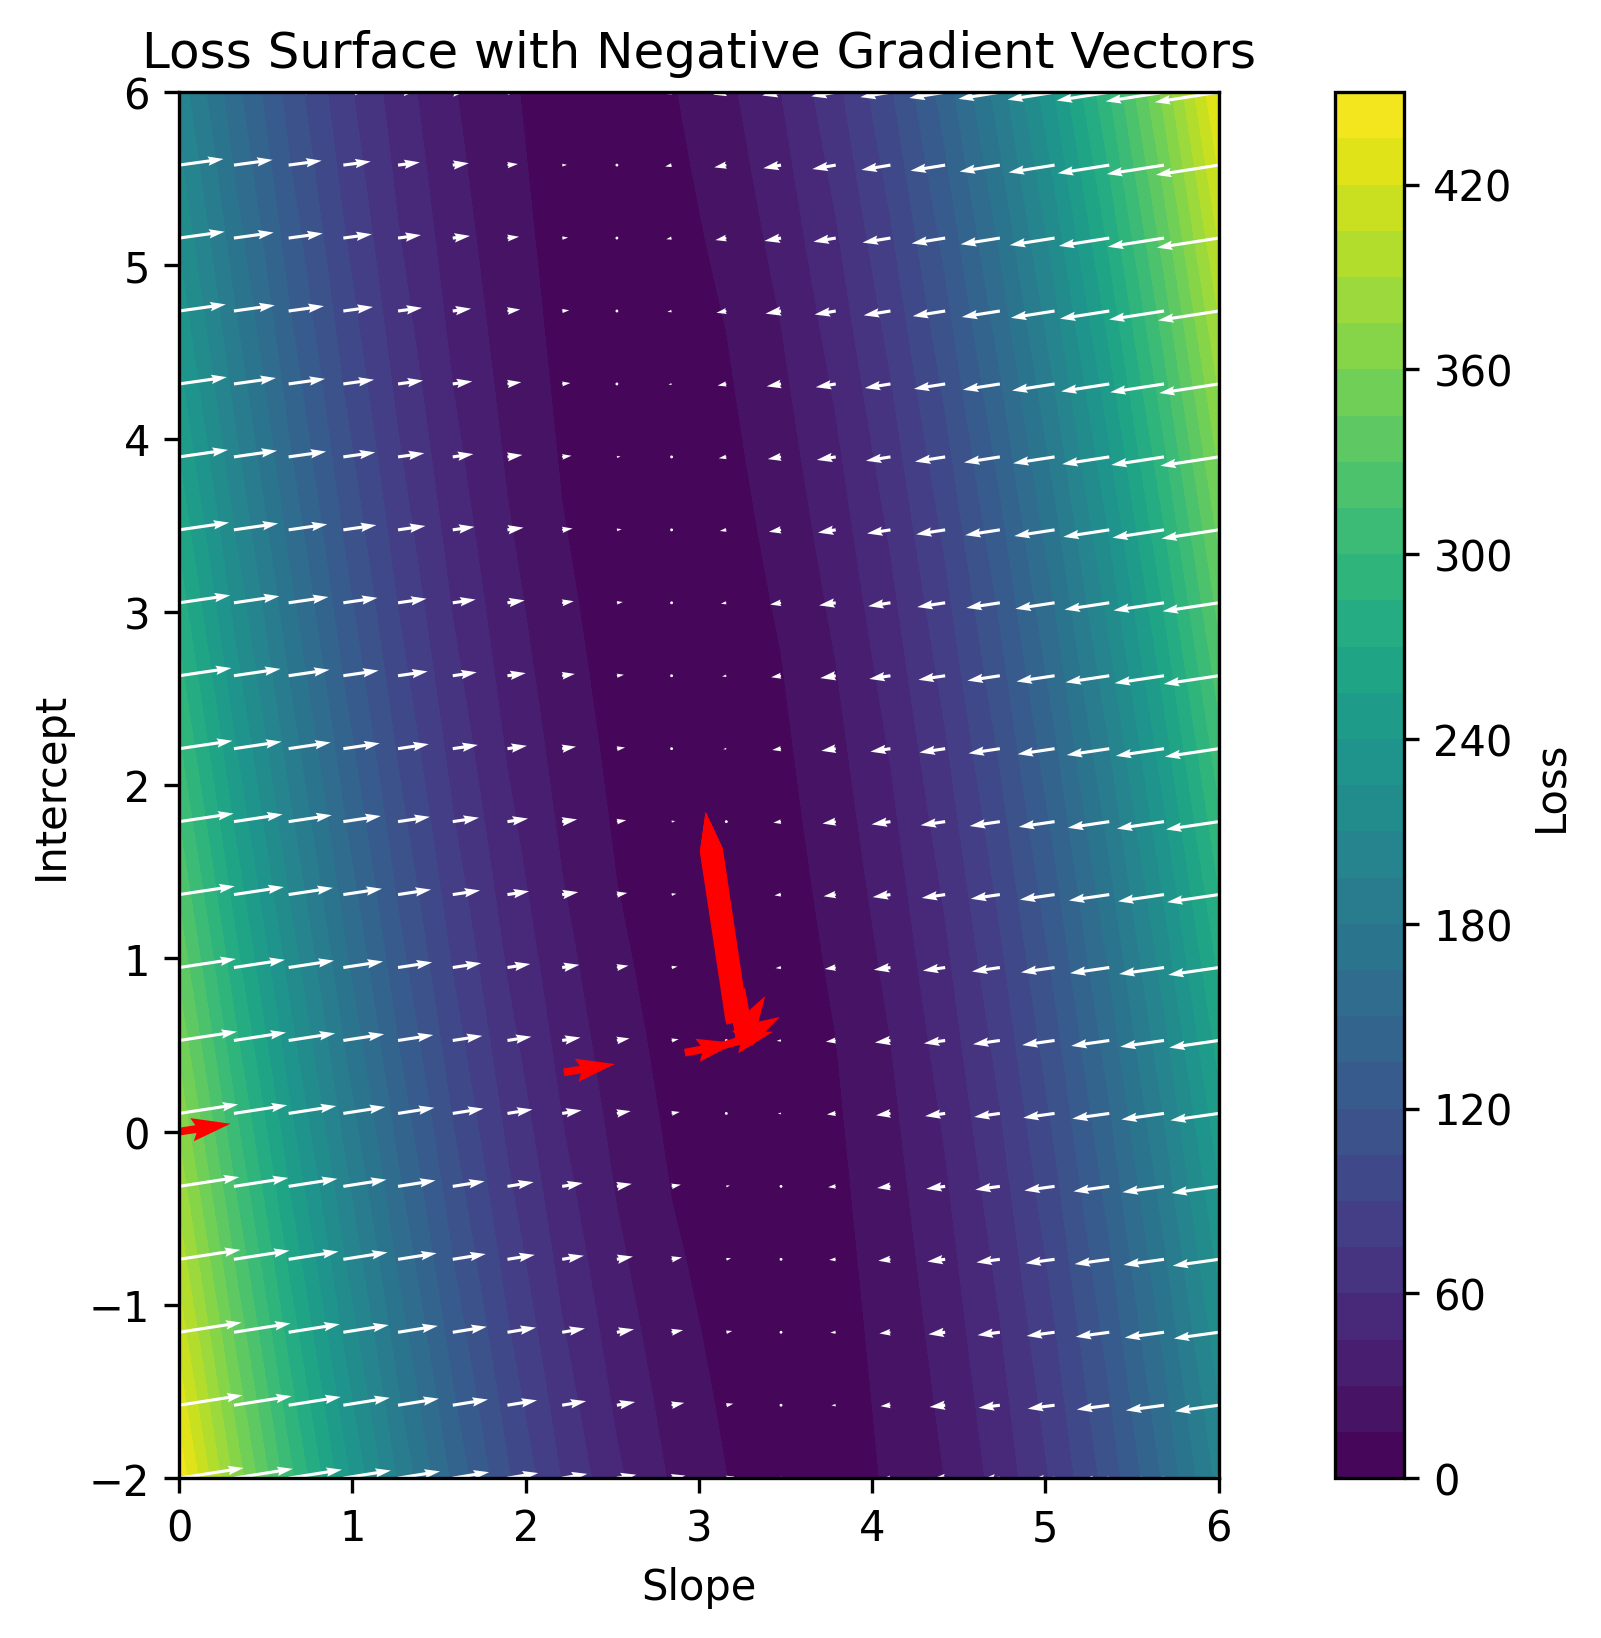

In [140]:
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 1. Generate synthetic dataset (y = 3x + 2 + noise)
torch.manual_seed(42)  # For reproducibility
n_samples = 100
X = torch.linspace(0, 10, n_samples).unsqueeze(1)  # Shape (n_samples, 1)
true_slope = 3.0
true_intercept = 2.0
noise = torch.randn(X.size()) * 2
y = true_slope * X + true_intercept + noise

m = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)

# 3. Loss function (MSE) and optimizer (SGD)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD([m, b], lr=0.01)

# 4. Compute gradients and plot quiver
def plot_loss_surface_with_gradients(model, X, y, slope_range, intercept_range):
    plt.figure(figsize=(10, 6), dpi=300)
    plt.axes().set_aspect('equal')
    slopes = np.linspace(slope_range[0], slope_range[1], 20)
    intercepts = np.linspace(intercept_range[0], intercept_range[1], 20)
    losses = np.zeros((len(slopes), len(intercepts)))
    grad_slope = np.zeros((len(slopes), len(intercepts)))
    grad_intercept = np.zeros((len(slopes), len(intercepts)))

    for i, slope in enumerate(slopes):
        for j, intercept in enumerate(intercepts):
            # Set model parameters
            m = torch.tensor(slope, requires_grad=True)
            b = torch.tensor(intercept, requires_grad=True)

            # Forward pass and loss calculation
            predictions = m*X + b
            loss = criterion(predictions, y)
            losses[i, j] = loss.item()

            # Zero out gradients
            optimizer.zero_grad()

            # Backward pass for gradient calculation
            loss.backward()

            # Store gradients of the slope and intercept
            grad_slope[i, j] = m.grad.item()
            grad_intercept[i, j] = b.grad.item()

    # Plot the loss surface as a contour plot
    S, I = np.meshgrid(slopes, intercepts)
    plt.contourf(S, I, losses.T, levels=30, cmap='viridis')
    plt.colorbar(label="Loss")

    # Use quiver to display the negative gradients
    plt.quiver(S, I, -grad_slope.T, -grad_intercept.T, color='white')
    plt.xlabel('Slope')
    plt.ylabel('Intercept')
    plt.title('Loss Surface with Negative Gradient Vectors')

# 5. Show the loss surface and gradients before training
plot_loss_surface_with_gradients(model, X, y, slope_range=(0, 6), intercept_range=(-2, 6))

# initialize the model weights and bias
m = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)
optimizer = torch.optim.SGD([m, b], lr=0.01)

# 6. Training loop
epochs = 200
for epoch in range(epochs):
    # Forward pass
    predictions = m*X + b
    loss = criterion(predictions, y)

    # Backward pass and gradient computation
    optimizer.zero_grad()
    loss.backward()
    u = m.grad.item()
    v = b.grad.item()
    plt.quiver(m.item(), b.item(), -u / np.sqrt(u**2 + v**2), -v / np.sqrt(u**2 + v**2), scale=20, color='red')
    # Update parameters
    optimizer.step()
plt.show()

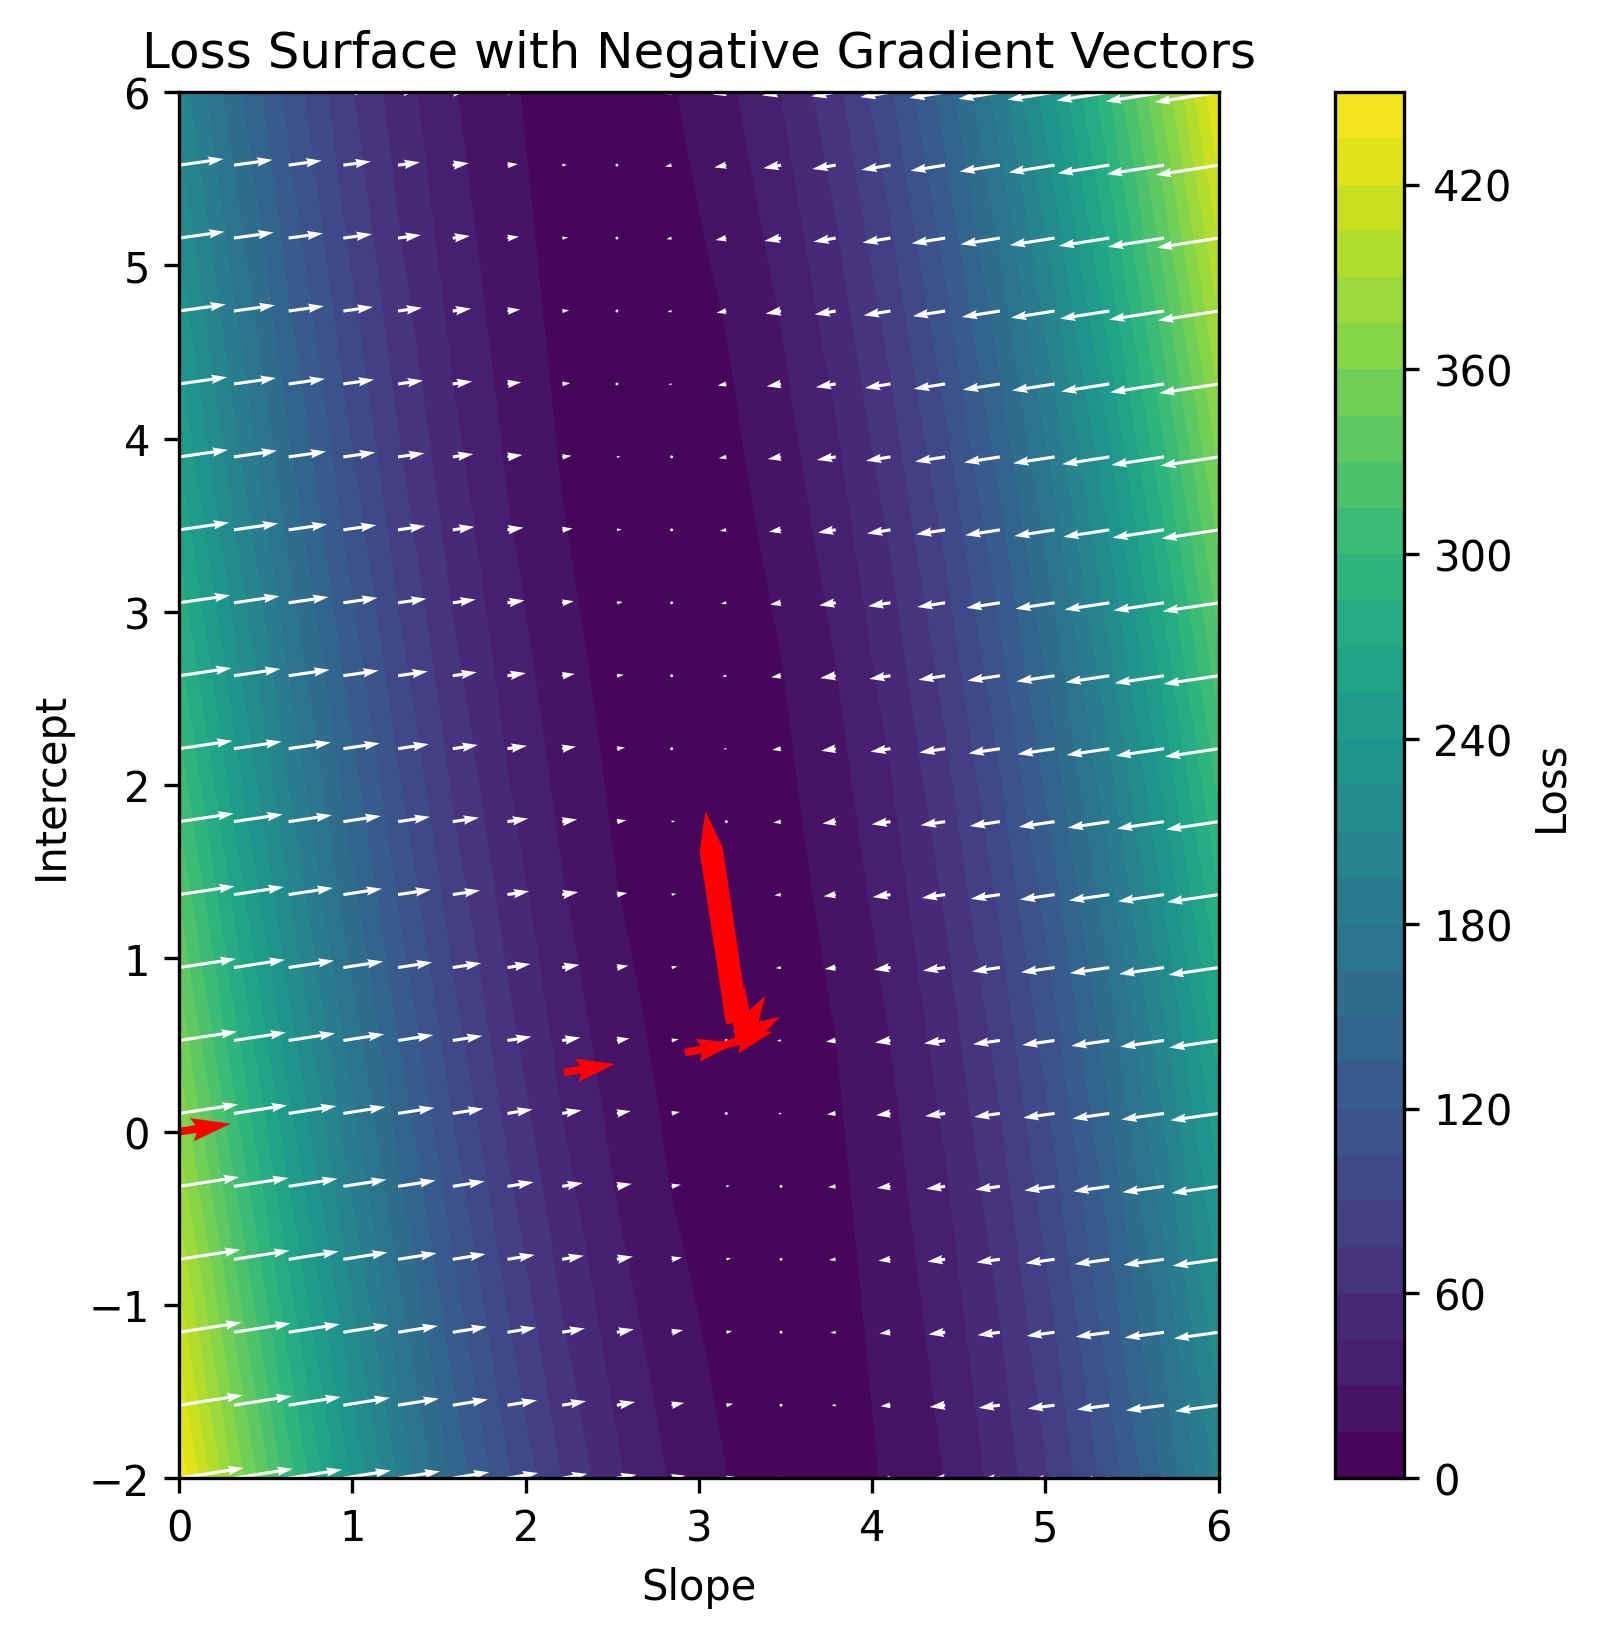

In [139]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# 2. Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # One input, one output

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel()

# 3. Loss function (MSE) and optimizer (SGD)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 4. Compute gradients and plot quiver
def plot_loss_surface_with_gradients(model, X, y, slope_range, intercept_range):
    plt.figure(figsize=(10, 6), dpi=300)
    plt.axes().set_aspect('equal')
    slopes = np.linspace(slope_range[0], slope_range[1], 20)
    intercepts = np.linspace(intercept_range[0], intercept_range[1], 20)
    losses = np.zeros((len(slopes), len(intercepts)))
    grad_slope = np.zeros((len(slopes), len(intercepts)))
    grad_intercept = np.zeros((len(slopes), len(intercepts)))

    for i, slope in enumerate(slopes):
        for j, intercept in enumerate(intercepts):
            # Forward pass and loss calculation
            model.linear.weight.data.fill_(slope)
            model.linear.bias.data.fill_(intercept)
            predictions = model(X)
            loss = criterion(predictions, y)
            losses[i, j] = loss.item()

            # Zero out gradients
            optimizer.zero_grad()

            # Backward pass for gradient calculation
            loss.backward()

            # Store gradients of the slope and intercept
            grad_slope[i, j] = model.linear.weight.grad.item()
            grad_intercept[i, j] = model.linear.bias.grad.item()

    # Plot the loss surface as a contour plot
    S, I = np.meshgrid(slopes, intercepts)
    plt.contourf(S, I, losses.T, levels=30, cmap='viridis')
    plt.colorbar(label="Loss")

    # Use quiver to display the negative gradients
    plt.quiver(S, I, -grad_slope.T, -grad_intercept.T, color='white')
    plt.xlabel('Slope')
    plt.ylabel('Intercept')
    plt.title('Loss Surface with Negative Gradient Vectors')

# 5. Show the loss surface and gradients before training
plot_loss_surface_with_gradients(model, X, y, slope_range=(0, 6), intercept_range=(-2, 6))

# initialize the model weights and bias
m = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(0.0, requires_grad=True)
optimizer = torch.optim.SGD([m, b], lr=0.01)

# 6. Training loop
epochs = 200
for epoch in range(epochs):
    # Forward pass
    predictions = m*X + b
    loss = criterion(predictions, y)

    # Backward pass and gradient computation
    optimizer.zero_grad()
    loss.backward()
    u = m.grad.item()
    v = b.grad.item()
    plt.quiver(m.item(), b.item(), -u / np.sqrt(u**2 + v**2), -v / np.sqrt(u**2 + v**2), scale=20, color='red')
    # Update parameters
    optimizer.step()
plt.show()